In [ ]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy import stats
import scipy.stats as st
import h5py
from sorting_data_pairwise_comparison import follow_behaviour_analysis
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from data_cleaning import findLongestConseqSubseq

In [39]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
#variable_name='mu'
variable_name='location'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump
analysis_window=analysis_methods.get("analysis_window")
monitor_fps=analysis_methods.get("monitor_fps")

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [40]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","bifuration_vr_locust_sta_black_cylinder","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values

    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

### Session 1.1: introduce helper functions to make plot and calculate speed

In [41]:
analysis_methods.update({"plotting_trajectory": False})

In [43]:
dir_list[26:]

['D:/MatrexVR_2024_Data/RunData/20241228_142015',
 'D:/MatrexVR_2024_Data/RunData/20241228_142015',
 'D:/MatrexVR_2024_Data/RunData/20241228_142015',
 'D:/MatrexVR_2024_Data/RunData/20241228_160619',
 'D:/MatrexVR_2024_Data/RunData/20241228_160619',
 'D:/MatrexVR_2024_Data/RunData/20241228_160619',
 'D:/MatrexVR_2024_Data/RunData/20241228_160619',
 'D:/MatrexVR_2024_Data/RunData/20241228_175057',
 'D:/MatrexVR_2024_Data/RunData/20241228_175057',
 'D:/MatrexVR_2024_Data/RunData/20241228_175057',
 'D:/MatrexVR_2024_Data/RunData/20241229_131452',
 'D:/MatrexVR_2024_Data/RunData/20241229_131452',
 'D:/MatrexVR_2024_Data/RunData/20241229_131452',
 'D:/MatrexVR_2024_Data/RunData/20241229_131452',
 'D:/MatrexVR_2024_Data/RunData/20241229_150225',
 'D:/MatrexVR_2024_Data/RunData/20241229_150225',
 'D:/MatrexVR_2024_Data/RunData/20241229_150225',
 'D:/MatrexVR_2024_Data/RunData/20241229_164846',
 'D:/MatrexVR_2024_Data/RunData/20241229_164846',
 'D:/MatrexVR_2024_Data/RunData/20241230_132654',


In [44]:
dir_list=dir_list[26:]
vr_no=vr_no[26:]

In [ ]:
dir_list=dir_list[-26:]
vr_no=vr_no[-26:]

In [ ]:
relative_pos_all_animals=[]
raster_across_animals=[]
trial_evaluation_across_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if Path(this_dir).is_dir()==False:
        continue
    agent_pattern = f"VR{this_vr}*agent_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    summary_pattern = f"VR{this_vr}*score_full.h5"
    agent_file = find_file(Path(this_dir), agent_pattern)
    focal_animal_file = find_file(Path(this_dir), xy_pattern)
    summary_file = find_file(Path(this_dir), summary_pattern)
    relative_pos,trial_evaluation_list,raster_pd,num_unfilled_gap=follow_behaviour_analysis(summary_file,focal_animal_file,agent_file,analysis_methods)
    if animal_id==0:
        largest_unfilled_gap=num_unfilled_gap
    elif num_unfilled_gap>largest_unfilled_gap:
        largest_unfilled_gap=num_unfilled_gap
    else:
        pass
    relative_pos_all_animals.append(relative_pos)
    trial_evaluation=pd.concat(trial_evaluation_list)
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    trial_evaluation_across_animals.append(trial_evaluation)
    raster_pd.insert(0, 'animal_id', np.repeat(animal_id,raster_pd.shape[0]))
    raster_across_animals.append(raster_pd)
    animal_id=animal_id+1
analysis_methods['largest_unfilled_gap']= largest_unfilled_gap

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_142015\VR1_2024-12-28_142029_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_142015\VR2_2024-12-28_142029_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_142015\VR3_2024-12-28_142029_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_160619\VR1_2024-12-28_160631_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_160619\VR2_2024-12-28_160631_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_160619\VR3_2024-12-28_160631_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_160619\VR4_2024-12-28_160631_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_175057\VR2_2024-12-28_175106_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_175057\VR3_2024-12-28_175106_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241228_175057\VR4_2024-12-28_175106_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_131452\VR1_2024-12-29_131528_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_131452\VR2_2024-12-29_131528_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_131452\VR3_2024-12-29_131528_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_131452\VR4_2024-12-29_131528_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_150225\VR2_2024-12-29_150234_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_150225\VR3_2024-12-29_150234_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_150225\VR4_2024-12-29_150234_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_164846\VR1_2024-12-29_164909_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241229_164846\VR3_2024-12-29_164909_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_132654\VR1_2024-12-30_132725_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_132654\VR2_2024-12-30_132725_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_132654\VR3_2024-12-30_132725_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_151407\VR1_2024-12-30_151421_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_151407\VR2_2024-12-30_151421_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_151407\VR3_2024-12-30_151421_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_170149\VR2_2024-12-30_170203_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20241230_170149\VR3_2024-12-30_170203_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20250103_162144\VR1_2025-01-03_162206_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20250103_162144\VR2_2025-01-03_162206_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :1 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20250103_162144\VR3_2025-01-03_162206_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

the length :2 of unfilled gap in D:\MatrexVR_2024_Data\RunData\20250103_162144\VR4_2025-01-03_162206_XY_full.h5


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid value encountered in divide
  angles = np.arccos(dot_product / focal_distance_fbf / agent_distance_fbf)
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\sorting_data_pairwise_comparison.py:211: RuntimeWarning: invalid

In [46]:
relative_pos_all_pd=pd.concat(relative_pos_all_animals,ignore_index=True)
relative_pos_all_pd['distance']=relative_pos_all_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)

In [47]:
stim_combination1='LeaderLocust_x_LeaderCylinder_black'
stim_combination2='LeaderCylinder_black_x_LeaderLocust'
# stim_combination1='LeaderLocust_x_InanimatedLeaderLocust_black'
# stim_combination2='InanimatedLeaderLocust_black_x_LeaderLocust'

In [48]:
pd1=relative_pos_all_pd[(relative_pos_all_pd['type']==stim_combination1) & (relative_pos_all_pd['distance']<10)]
pd2=relative_pos_all_pd[(relative_pos_all_pd['type']==stim_combination2) & (relative_pos_all_pd['distance']<10)]

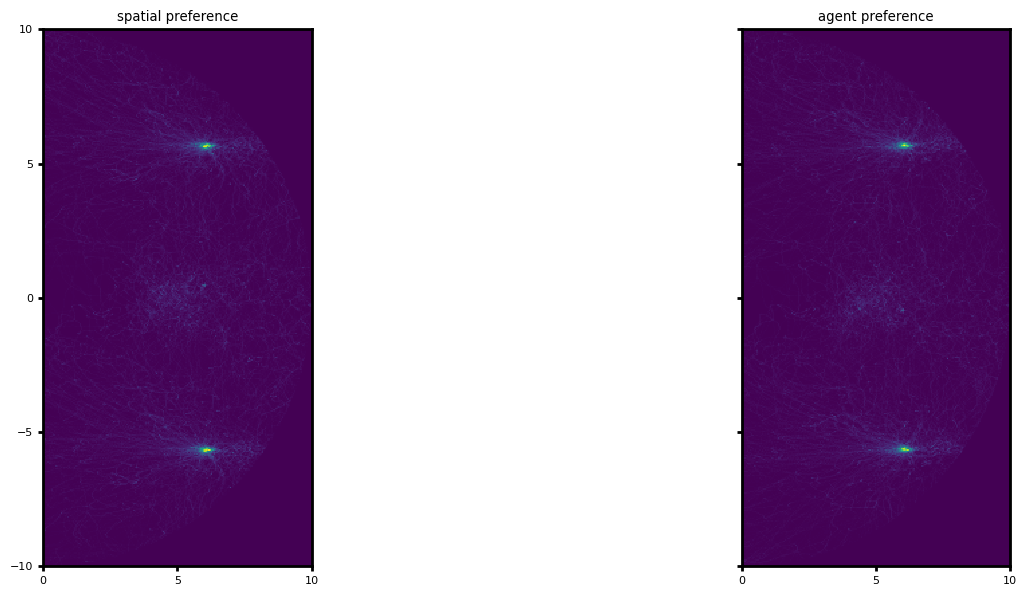

In [55]:
xlimit=(0,10)
ylimit=(-10,10)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
ax1.hist2d(np.hstack((pd1['x'].values,pd2['x'].values)),np.hstack((pd1['y'].values,pd2['y'].values)),bins=400)
ax2.hist2d(np.hstack((pd1['x'].values,pd2['x'].values)),np.hstack((pd1['y'].values,pd2['y'].values*-1)),bins=400)
ax1.set(
yticks=[-10,-5,0,5,10],
xticks=[0,5,10],
xlim=xlimit,ylim=ylimit,title='spatial preference',adjustable='box', aspect='equal')
ax2.set(
yticks=[-10,-5,0,5,10],
xticks=[0,5,10],
xlim=xlimit,ylim=ylimit,title='agent preference',adjustable='box', aspect='equal')
plt.show()

In [ ]:
thresholds=[2,5,8,11,14]
spatial_preference_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
social_preference_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
epochs_l_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
epochs_r_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
epochs_exp_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
epochs_con_animals=np.zeros((len(thresholds),len(relative_pos_all_animals),relative_pos_all_animals[0]['type'].unique().shape[0]))
for i in range(len(relative_pos_all_animals)):
    this_animal_relation=relative_pos_all_animals[i]
    type_no=0
    epochs_exp_list=[]
    epochs_con_list=[]
    epochs_r_list=[]
    epochs_l_list=[]
    relative_pos_list1=[]
    relative_pos_list2=[] 
    relative_distance_list1=[]
    relative_distance_list2=[]
    for key,grp in this_animal_relation.groupby('type'):
        focal_xy = np.vstack((grp["x"].values,grp["y"].values))
        relative_distance=LA.norm(focal_xy,axis=0)
        if key==stim_combination2:
            relative_pos_list1.append(focal_xy)
            relative_distance_list1.append(relative_distance)
        elif key==stim_combination1:
            relative_pos_list2.append(focal_xy)
            relative_distance_list2.append(relative_distance)        
        for j,this_threshold in enumerate(thresholds):
            epochs_forR=np.sum(grp[relative_distance<this_threshold]["agent_id"].values)
            epochs_forL=grp[relative_distance<this_threshold]["agent_id"].values.shape[0]-np.sum(grp[relative_distance<this_threshold]["agent_id"].values)
            preferL_index=(epochs_forL-epochs_forR)/(epochs_forR+epochs_forL)
            spatial_preference_animals[j,i,type_no]=preferL_index
            if key==stim_combination2:
                print(key,type_no)
                epochs_exp=epochs_forR
                epochs_con=epochs_forL
                epochs_l_animals[j,i,type_no]=epochs_forL
                epochs_r_animals[j,i,type_no]=epochs_forR
                epochs_exp_animals[j,i,type_no]=epochs_exp
                epochs_con_animals[j,i,type_no]=epochs_con
            elif key==stim_combination1:
                print(key,type_no)
                epochs_exp=epochs_forL
                epochs_con=epochs_forR
                social_preference_animals[j,i,type_no]=prefer_exp_index
                epochs_l_animals[j,i,type_no]=epochs_forL
                epochs_r_animals[j,i,type_no]=epochs_forR
                epochs_exp_animals[j,i,type_no]=epochs_exp
                epochs_con_animals[j,i,type_no]=epochs_con
            else:
                epochs_exp=np.nan
                epochs_con=np.nan
            prefer_exp_index=(epochs_exp-epochs_con)/(epochs_exp+epochs_con)
            social_preference_animals[j,i,type_no]=prefer_exp_index
        type_no=type_no+1

In [51]:
left_right_preference_across_animals=(epochs_l_animals[:,:,1]+epochs_l_animals[:,:,3]-epochs_r_animals[:,:,1]-epochs_r_animals[:,:,3])/(epochs_l_animals[:,:,1]+epochs_l_animals[:,:,3]+epochs_r_animals[:,:,1]+epochs_r_animals[:,:,3])
exp_con_preference_across_animals=(epochs_exp_animals[:,:,1]+epochs_exp_animals[:,:,3]-epochs_con_animals[:,:,1]-epochs_con_animals[:,:,3])/(epochs_exp_animals[:,:,1]+epochs_exp_animals[:,:,3]+epochs_con_animals[:,:,1]+epochs_con_animals[:,:,3])

C:\Users\neuroPC\AppData\Local\Temp\ipykernel_23876\1865791776.py:1: RuntimeWarning: invalid value encountered in divide
  left_right_preference_across_animals=(epochs_l_animals[:,:,1]+epochs_l_animals[:,:,3]-epochs_r_animals[:,:,1]-epochs_r_animals[:,:,3])/(epochs_l_animals[:,:,1]+epochs_l_animals[:,:,3]+epochs_r_animals[:,:,1]+epochs_r_animals[:,:,3])
C:\Users\neuroPC\AppData\Local\Temp\ipykernel_23876\1865791776.py:2: RuntimeWarning: invalid value encountered in divide
  exp_con_preference_across_animals=(epochs_exp_animals[:,:,1]+epochs_exp_animals[:,:,3]-epochs_con_animals[:,:,1]-epochs_con_animals[:,:,3])/(epochs_exp_animals[:,:,1]+epochs_exp_animals[:,:,3]+epochs_con_animals[:,:,1]+epochs_con_animals[:,:,3])


In [52]:
save_output= analysis_methods.get("save_output")
preference_plot, (ax1,ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(20, 4), tight_layout=True
)
xaxis_points=np.repeat(thresholds,len(relative_pos_all_animals)).reshape(len(thresholds),len(relative_pos_all_animals))
ax1.scatter(xaxis_points,left_right_preference_across_animals,alpha=0.2)
mean_index=np.mean(xaxis_points,axis=1)
mean_response=np.nanmean(left_right_preference_across_animals,axis=1)
sem_response=np.nanstd(left_right_preference_across_animals, axis=1, ddof=1) / np.sqrt(left_right_preference_across_animals.shape[1])
ax1.errorbar(
    mean_index,
    mean_response,
    yerr=sem_response,
    c='k',
    fmt="o",
    elinewidth=2,
    capsize=3,
)
ax1.set(
    ylabel="(postive means prefer left)",
    yticks=[-1,0,1],
    xticks=thresholds,
    xlabel="ROI size (cm)",
    title="spatial preference"
)
ax2.scatter(xaxis_points,exp_con_preference_across_animals,alpha=0.2)
mean_index=np.mean(xaxis_points,axis=1)
mean_response=np.nanmean(exp_con_preference_across_animals,axis=1)
sem_response=np.nanstd(exp_con_preference_across_animals, axis=1, ddof=1) / np.sqrt(exp_con_preference_across_animals.shape[1])
ax2.errorbar(
    mean_index,
    mean_response,
    yerr=sem_response,
    c='k',
    fmt="o",
    elinewidth=2,
    capsize=3,
)
ax2.set(
    ylabel="(positive means prefer exp)",
    yticks=[-1,0,1],
    xticks=thresholds,
    xlabel="ROI size (cm)",
    title="visual preference"
)
fig_name=f"bifurcation_vr_gregarious_locust_black_cylinder_preference_index.svg"
if save_output==True:
    preference_plot.savefig(fig_name)

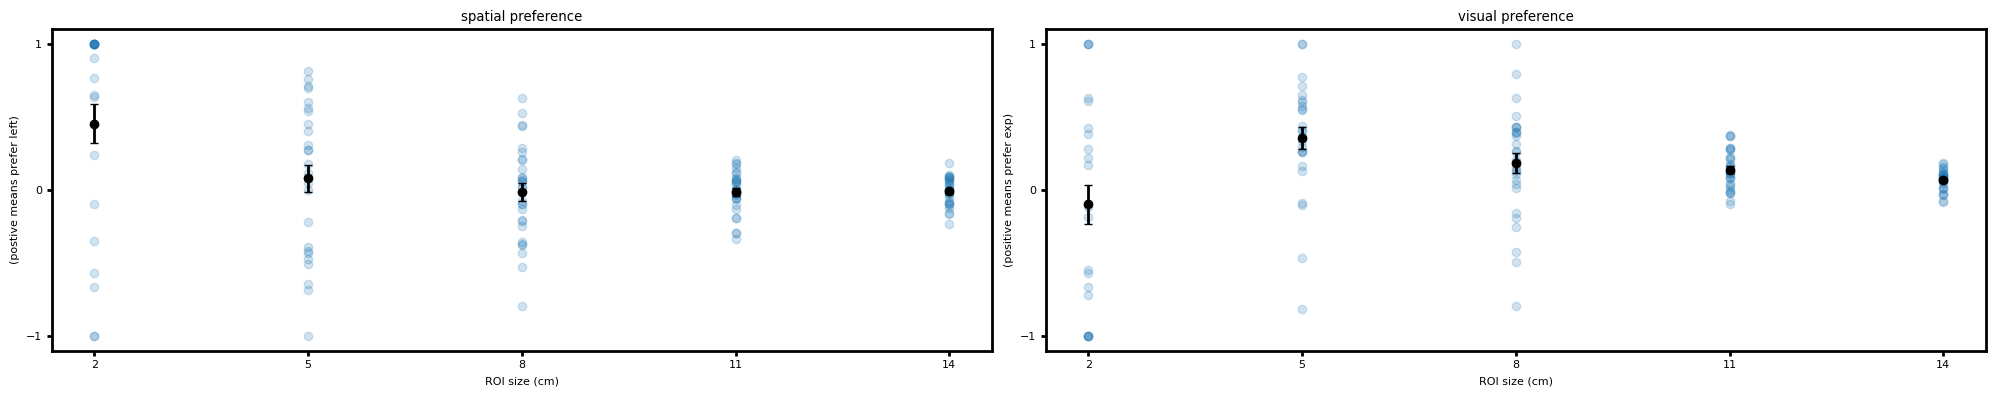

In [53]:
plt.show()

In [36]:
#preference_threshold_animals format (thresholds x animals x type)

left_right_preference, subplots = plt.subplots(
    nrows=1, ncols=spatial_preference_animals.shape[2], figsize=(20, 4), tight_layout=True
)
xaxis_points=np.repeat(thresholds,len(relative_pos_all_animals)).reshape(len(thresholds),len(relative_pos_all_animals))
for choice_type in range(spatial_preference_animals.shape[2]):
    subplots[choice_type].scatter(xaxis_points,spatial_preference_animals[:,:,choice_type],alpha=0.2)
    subplots[choice_type].set_xlabel("ROI size (cm)")
    mean_index=np.mean(xaxis_points,axis=1)
    mean_response=np.nanmean(spatial_preference_animals[:,:,choice_type],axis=1)
    sem_response=np.nanstd(spatial_preference_animals[:,:,choice_type], axis=1, ddof=1) / np.sqrt(
    spatial_preference_animals[:,:,choice_type].shape[1]
)
    subplots[choice_type].errorbar(
        mean_index,
        mean_response,
        yerr=sem_response,
        c='k',
        fmt="o",
        elinewidth=2,
        capsize=3,
    )
    #
subplots[0].set_ylabel("preference index (postive means prefer left)")

Text(0, 0.5, 'preference index (postive means prefer left)')

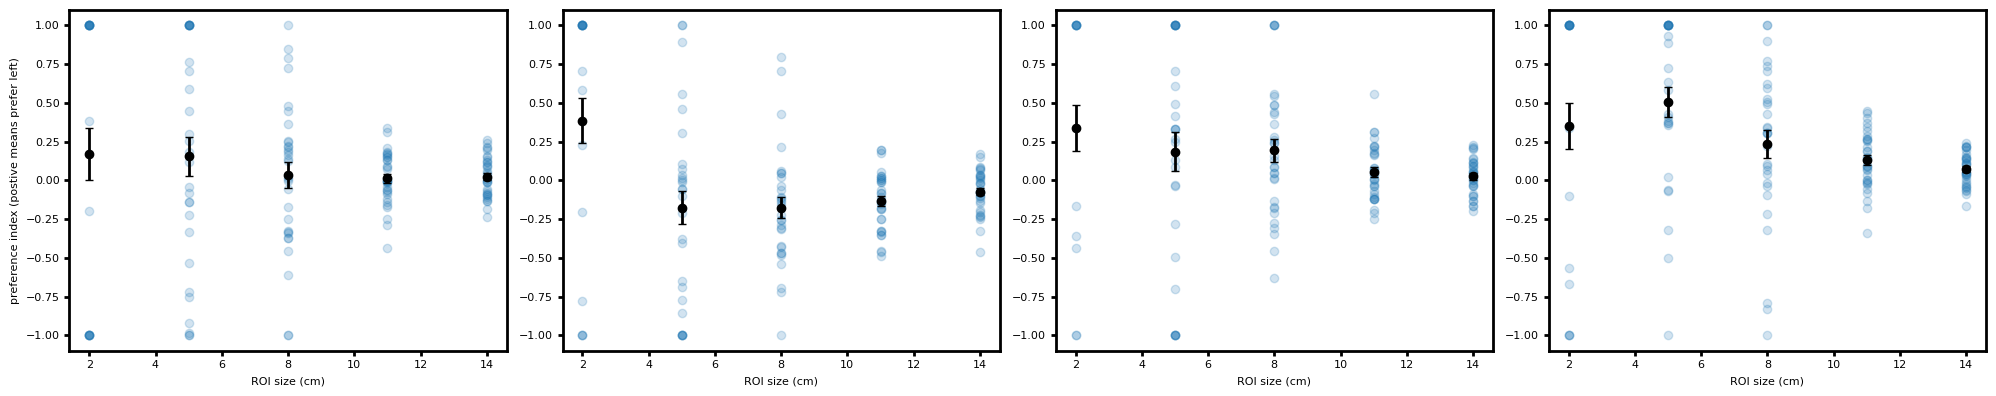

In [37]:
plt.show()